![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import any additional modules and start coding below
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [96]:
# read in dataframe 
rental_data = pd.read_csv("rental_info.csv")

# check data head
rental_data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [97]:
# check rental data column types
rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [98]:
# covert rental_date and return date to a datetime object
rental_data['return_date'] = pd.to_datetime(rental_data['return_date'])
rental_data['rental_date'] = pd.to_datetime( rental_data['rental_date'])

# create renal days column
diff =  rental_data['return_date'] - rental_data['rental_date']  
rental_data["rental_length_days"] = diff.dt.days

# extract dummy columns from special features
rental_data["deleted_scenes"] =  np.where(rental_data["special_features"].str.contains("Deleted Scenes"), 1,0)

rental_data["behind_the_scenes"] = np.where(rental_data["special_features"].str.contains("Behind the Scenes"), 1,0)

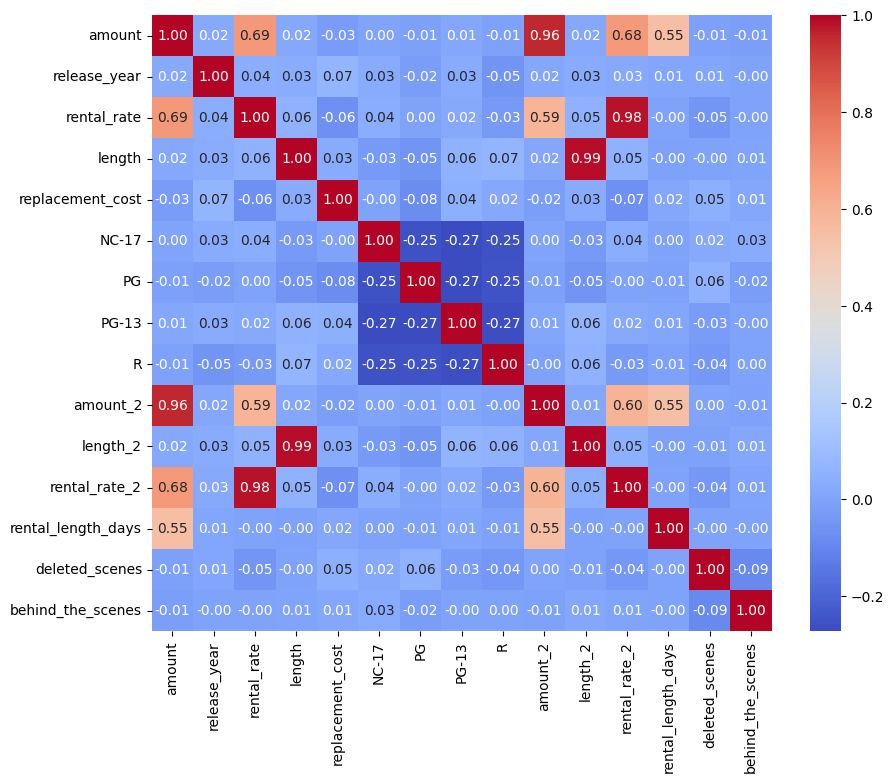

In [99]:
# plot correlation of variables
cor_mat = rental_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [100]:
FEATURES = ['release_year', 'replacement_cost', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2', 'deleted_scenes',
       'behind_the_scenes', 'amount', 'rental_rate', 'length']
X = rental_data[FEATURES]
y = rental_data['rental_length_days']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [101]:
# train model
lasso = Lasso(random_state=9, alpha=0.1)

# fit model
lasso.fit(X_train, y_train)

lass_coef = lasso.coef_ > 0

X_train_s = X_train.iloc[:,lass_coef]
X_test_s = X_test.iloc[:,lass_coef]

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor()
}

# Define parameter grids for RandomizedSearchCV
param_grids = {
    'Random Forest': {
        'n_estimators': np.arange(1, 101, 1),
        'max_depth': np.arange(1, 11, 1),
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Fine-tune each model with RandomizedSearchCV and print scores
for name, model in models.items():
    if name in param_grids:  # Check if there are hyperparameters to tune
        param_grid = param_grids[name]
        random_search = RandomizedSearchCV(model, param_grid, cv=5, random_state=9)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        pred_y = best_model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        pred_y = model.predict(X_test)

    score = mean_squared_error(y_test, pred_y)
    best_mse = score
    print(f'{name}: {score}')


Linear Regression: 2.9417238646976
Random Forest: 2.220623874792082
Decision Tree: 2.211472217860603


In [103]:
rental_data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1
